[587122.0376616  592454.60034661]
[6656823.95732363 6659012.41064553]


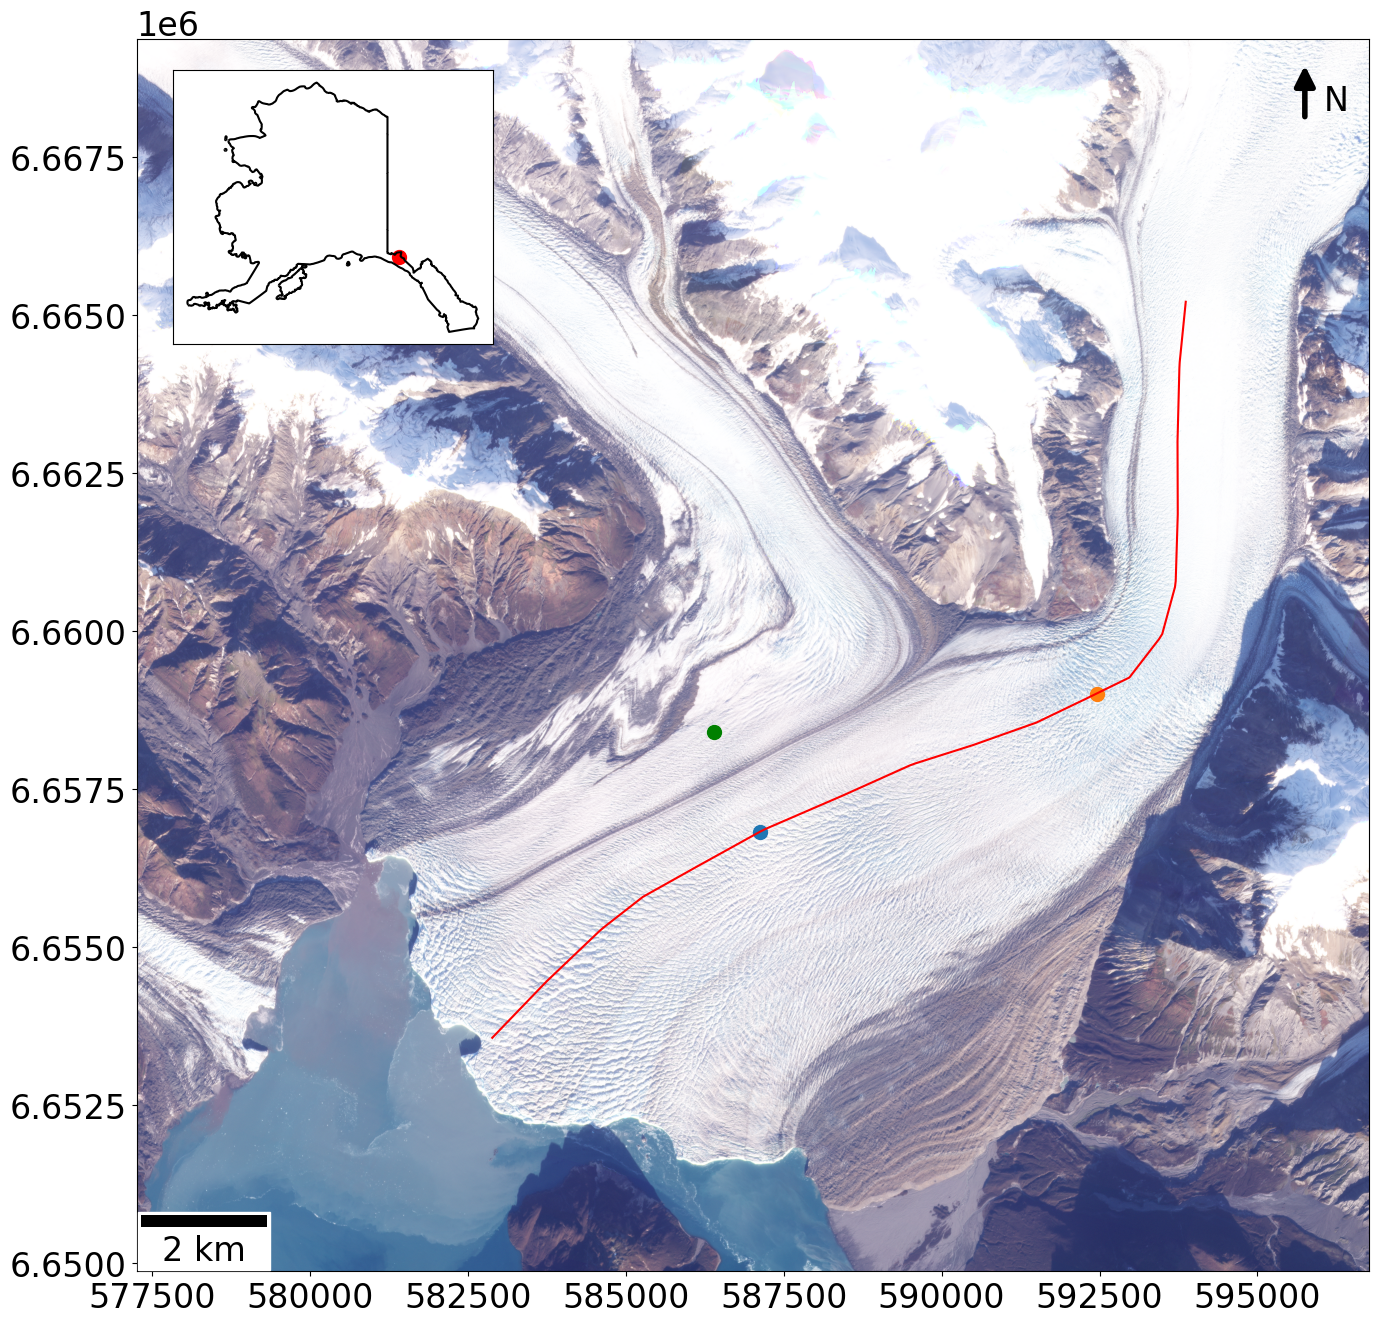

In [12]:
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.enums import Resampling
from pyproj import Transformer
from rasterio.windows import Window
import pandas as pd
from pyproj import Proj, transform
import geopandas as gpd
from matplotlib_scalebar.scalebar import ScaleBar

fs = 24  # font size


def pct_clip(array, pct=[2, 98]):
    array_min, array_max = np.nanpercentile(array, pct[0]), np.nanpercentile(
        array, pct[1]
    )
    clip = (array - array_min) / (array_max - array_min)
    clip[clip > 1] = 1
    clip[clip < 0] = 0
    return clip


with rio.open("Planet_Hubbard.tif") as src:
    with rio.open(
        "RGB_Temp.tif",
        "w+",
        driver="GTiff",
        dtype=rio.float32,
        count=3,
        crs=src.crs,
        width=src.width,
        height=src.height,
        transform=src.transform,
    ) as dst:
        V = pct_clip(src.read(1))
        dst.write(V, 1)
        V = pct_clip(src.read(2))
        dst.write(V, 2)
        V = pct_clip(src.read(3))
        dst.write(V, 3)

# Create a larger figure
fig, ax = plt.subplots(figsize=(16, 16))

window = rio.windows.Window(3000, 3000, 6500, 6500)
with rio.open("RGB_Temp.tif") as src2:
    data = src2.read(window=window)
    transform = rio.windows.transform(window, src2.transform)
    show(data, transform=transform, ax=ax)


########################
# add a flowline
points = pd.read_csv("centerline_points_100m.csv")
transformer = Transformer.from_crs("epsg:3413", "epsg:32607")  # UTM 6N
x, y = transformer.transform(points.X.to_numpy(), points.Y.to_numpy())
ax.plot(x, y, "r")

########################
# add points for velocity plots
points = pd.read_csv("centerline_points_3000m.csv")
transformer = Transformer.from_crs("epsg:3413", "epsg:32607")  # UTM 6N
points_X, points_Y = transformer.transform(points.X.to_numpy(), points.Y.to_numpy())

# plug in these coordinates to victors velocity datacube

# points_x = np.array([points_X[1], points_X[5]])  # specify your target x coordinate
# points_y = np.array([points_Y[1], points_Y[5]])  # specify your target y coordinate


########################

# dense points around ice fall

points = pd.read_csv("centerline_points_1000m.csv")
transformer = Transformer.from_crs("epsg:3413", "epsg:32607")  # UTM 6N
points_X, points_Y = transformer.transform(points.X.to_numpy(), points.Y.to_numpy())

points_x = np.array([points_X[13], points_X[7]])  # specify your target x coordinate
points_y = np.array([points_Y[13], points_Y[7]])  # specify your target y coordinate
########################
print(points_x)
print(points_y)

for i in range(len(points_x)):
    ax.scatter(points_x[i], points_y[i], s=100)

########################
# add inset map

# Read the CSV file into a DataFrame
df = gpd.read_file("Alaska_outline_cropped.shp")
df = df.to_crs(epsg=32607)

# Add a subplot with a black background
ax_map = fig.add_axes([0.15, 0.675, 0.2, 0.2], facecolor="white")

# Plot the shapefile on the map subplot
df.plot(ax=ax_map, color="black")
ax_map.scatter([590839], [6657969], alpha=1, c="red", s=100)

ax.scatter([586400], [6658400], c="green", s=100)

# ax_map.axis('off')
# Turn off the ticks and axis labels
ax_map.tick_params(
    axis="both", which="both", bottom=False, top=False, left=False, right=False
)
ax_map.set_xticks([])
ax_map.set_yticks([])

########################
# Add a scale bar to the plot
scalebar = ScaleBar(
    1, location="lower left", font_properties={"size": fs}
)  # , frameon=False, font_properties={'family': 'serif', 'size': fs})
ax.add_artist(scalebar)

########################
# Add a north arrow
arrow_x = 595750  # x-coordinate of the arrow
arrow_y = 6669000  # y-coordinate of the arrow
arrow_length = 900  # Length of the arrow
arrow_props = dict(
    facecolor="black", arrowstyle="-|>", linewidth=4, mutation_scale=30
)  # Arrow properties

# Add the arrow to the plot
ax.annotate(
    "",
    xy=(arrow_x, arrow_y),
    xytext=(arrow_x, arrow_y - arrow_length),
    arrowprops=arrow_props,
)


# Add a label for the north arrow
ax.text(
    arrow_x + 300,
    arrow_y - 600,
    "N",
    ha="left",
    va="center",
    fontsize=fs,
    color="black",
)

# Get all text objects in the figure
text_objs = plt.gcf().findobj(plt.Text)

# Change font size for all text objects
font_size = fs  # Change this to the font size you desire
for text_obj in text_objs:
    text_obj.set_fontsize(font_size)

plt.show
plt.savefig("map_inset.png")
